# CIFAR-10 Classification with MobileNet (Simpler Version)

The process for classifying CIFAR-10 images using MobileNetV2 involves several steps. First, we import the necessary libraries, including PyTorch, Torchvision, and other utility libraries. We apply the same data transformations as with SqueezeNet, including normalization and data augmentation techniques like random horizontal flipping and random cropping. The CIFAR-10 dataset is loaded in the same manner, and we split the training dataset into training and validation sets. We then create data loaders for training, validation, and testing. 

Next, we check if a GPU is available and use it if possible. For the model setup, we replace SqueezeNet with MobileNetV2, defining the model and moving it to the specified device. We define the loss function and optimizer, and set up a learning rate scheduler as before. The training and validation functions remain the same, involving forward passes, loss computation, backward passes, and model parameter updates during training, while evaluating performance on the validation set during validation.

We proceed with the training and validation loop, training and validating the model over multiple epochs, and storing the loss and accuracy for each epoch. After training, we plot the training and validation loss and accuracy curves to visualize the model's performance over time. Finally, we evaluate the model on the test set and print the classification report to assess the model's performance on unseen data.

Files already downloaded and verified
Files already downloaded and verified


/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.2332, Train Acc: 0.1677, Valid Loss: 2.1573, Valid Acc: 0.2060
Epoch 2/5, Train Loss: 2.1460, Train Acc: 0.2135, Valid Loss: 2.1129, Valid Acc: 0.2421
Epoch 3/5, Train Loss: 2.0896, Train Acc: 0.2515, Valid Loss: 2.0401, Valid Acc: 0.2751
Epoch 4/5, Train Loss: 2.0349, Train Acc: 0.2754, Valid Loss: 2.0131, Valid Acc: 0.2822
Epoch 5/5, Train Loss: 2.0122, Train Acc: 0.2846, Valid Loss: 2.0075, Valid Acc: 0.2892


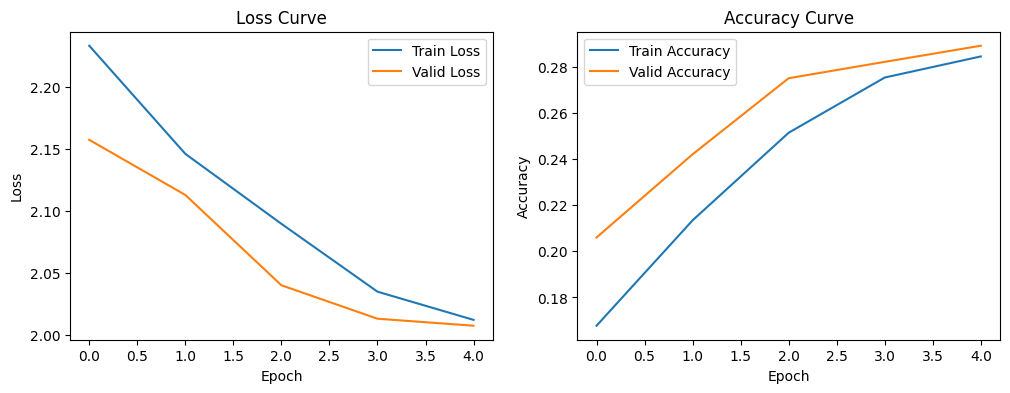

              precision    recall  f1-score   support

    airplane       0.19      0.69      0.30      1000
  automobile       0.00      0.00      0.00      1000
        bird       0.00      0.00      0.00      1000
         cat       0.23      0.51      0.31      1000
        deer       0.00      0.00      0.00      1000
         dog       0.45      0.23      0.30      1000
        frog       0.00      0.00      0.00      1000
       horse       0.42      0.69      0.52      1000
        ship       0.00      0.00      0.00      1000
       truck       0.37      0.75      0.50      1000

    accuracy                           0.29     10000
   macro avg       0.17      0.29      0.19     10000
weighted avg       0.17      0.29      0.19     10000



/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Define the transformations for the train and test sets
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split training dataset into train and validation
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define SqueezeNet model
model = torchvision.models.squeezenet1_1(pretrained=False, num_classes=10)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training function
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training and validation loop
num_epochs = 5
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_acc = validate(model, valid_loader, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

# We plot the training and validation loss and accuracy curves
# Plot training and validation curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()



# Finally, we evaluate the model on the test set and print the classification report:
# Evaluate on test set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=test_dataset.classes))


# Mobilenet v2 - 50 Epochs

We begin by importing the necessary libraries, including PyTorch, Torchvision, and other utility libraries such as `transforms`, `nn`, `optim`, `lr_scheduler`, and `DataLoader`. We also import the `classification_report` from scikit-learn and `matplotlib.pyplot` for plotting. 

For data preparation, we define two sets of transformations: one for the training set and one for the test set. The training set transformations include random horizontal flipping, random cropping, color jitter, random rotation, and normalization. The test set transformations include only normalization. The CIFAR-10 dataset is then loaded with the defined transformations. The training dataset is split into training and validation sets, with 80% allocated for training and 20% for validation. Data loaders for training, validation, and testing are created with a batch size of 128, with shuffling enabled for the training loader.

Next, we check if a GPU is available and use it if possible. For the model setup, we replace SqueezeNet with MobileNetV2. The model is defined, with the classifier layer modified to match the number of classes in CIFAR-10. The model is then moved to the specified device (GPU or CPU). The loss function is defined as `CrossEntropyLoss`. The optimizer is Adam with a learning rate of 0.0001 and weight decay of 1e-4. A learning rate scheduler `ReduceLROnPlateau` is set up to reduce the learning rate by a factor of 0.5 if the validation loss does not improve for 5 consecutive epochs.

The training function performs a forward pass, computes the loss, performs a backward pass, and updates the model parameters. It also keeps track of the running loss and accuracy. The validation function evaluates the model on the validation set, computing the loss and accuracy without updating the model parameters.

The model is trained and validated over 50 epochs. For each epoch, the training and validation loss and accuracy are computed and stored. The learning rate scheduler is updated based on the validation loss. The training and validation loss and accuracy curves are plotted to visualize the model's performance over time.

Finally, the model is evaluated on the test set. The predictions are compared to the true labels, and a classification report is printed to assess the model's performance.

Files already downloaded and verified
Files already downloaded and verified


/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/codespace/.python/current/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 2.2808, Train Acc: 0.1303, Valid Loss: 2.1320, Valid Acc: 0.1941
Epoch 2/50, Train Loss: 2.0818, Train Acc: 0.2120, Valid Loss: 1.9713, Valid Acc: 0.2515
Epoch 3/50, Train Loss: 1.9448, Train Acc: 0.2679, Valid Loss: 1.8294, Valid Acc: 0.3135
Epoch 4/50, Train Loss: 1.8621, Train Acc: 0.3051, Valid Loss: 1.7797, Valid Acc: 0.3373
Epoch 5/50, Train Loss: 1.8061, Train Acc: 0.3359, Valid Loss: 1.7478, Valid Acc: 0.3546
Epoch 6/50, Train Loss: 1.7609, Train Acc: 0.3514, Valid Loss: 1.6875, Valid Acc: 0.3758
Epoch 7/50, Train Loss: 1.7298, Train Acc: 0.3660, Valid Loss: 1.6646, Valid Acc: 0.3884
Epoch 8/50, Train Loss: 1.7016, Train Acc: 0.3807, Valid Loss: 1.6457, Valid Acc: 0.3926
Epoch 9/50, Train Loss: 1.6775, Train Acc: 0.3845, Valid Loss: 1.6228, Valid Acc: 0.4058
Epoch 10/50, Train Loss: 1.6549, Train Acc: 0.3971, Valid Loss: 1.6104, Valid Acc: 0.4128
Epoch 11/50, Train Loss: 1.6410, Train Acc: 0.4019, Valid Loss: 1.5907, Valid Acc: 0.4184
Epoch 12/50, Train 

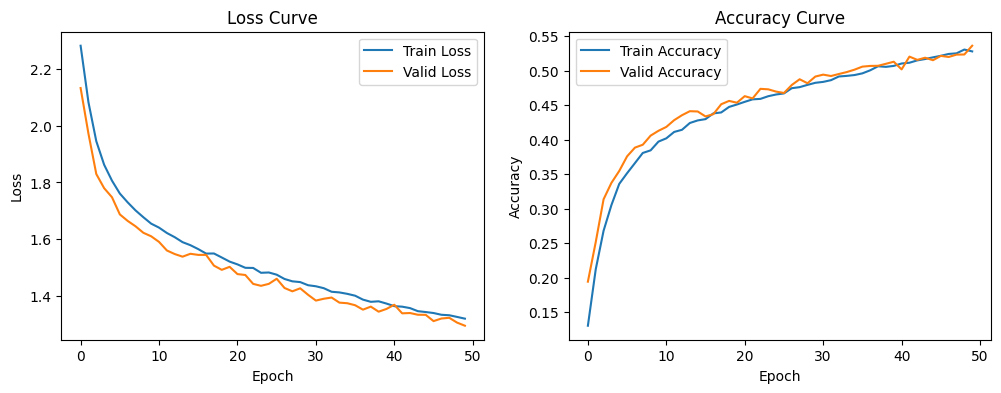

              precision    recall  f1-score   support

    airplane       0.55      0.66      0.60      1000
  automobile       0.71      0.73      0.72      1000
        bird       0.50      0.38      0.43      1000
         cat       0.34      0.25      0.29      1000
        deer       0.50      0.40      0.44      1000
         dog       0.41      0.59      0.48      1000
        frog       0.63      0.60      0.62      1000
       horse       0.56      0.65      0.61      1000
        ship       0.71      0.69      0.70      1000
       truck       0.67      0.65      0.66      1000

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.55     10000
weighted avg       0.56      0.56      0.55     10000



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Define the transformations for the train and test sets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split training dataset into train and validation
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define SqueezeNet model
model = torchvision.models.squeezenet1_1(pretrained=False)
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.5),
    nn.Conv2d(512, 10, kernel_size=1)
)
model.num_classes = 10
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Training function
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training and validation loop
num_epochs = 50
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_acc = validate(model, valid_loader, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    scheduler.step(valid_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

# Plot training and validation curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

# Evaluate on test set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=test_dataset.classes))
